In [85]:
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
from matplotlib.dates import DateFormatter, WeekdayLocator,DayLocator, MONDAY
from matplotlib.finance import candlestick_ohlc

Populating the interactive namespace from numpy and matplotlib


In [89]:
pylab.rcParams['figure.figsize'] = (15, 9) 

#I didn't write this

def pandas_candlestick_ohlc(dat, stick = "day", otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
 
    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdat = dat.loc[:,["Open", "High", "Low", "Close"]]
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
 
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
 
    plt.show()

In [21]:
newsdata = pd.read_csv('Combined_News_DJIA.csv')

In [22]:
redditdata = pd.read_csv('RedditNews.csv')

In [23]:
stockdata = pd.read_csv('DJIA_table.csv')

In [24]:
newsdata.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree 

In [45]:
Tesladf = newsdata[newsdata.Top1.str.contains('Tesla') | newsdata.Top2.str.contains('Tesla') | newsdata.Top3.str.contains('Tesla') | newsdata.Top4.str.contains('Tesla') | newsdata.Top5.str.contains('Tesla') | newsdata.Top6.str.contains('Tesla') | newsdata.Top7.str.contains('Tesla') | newsdata.Top8.str.contains('Tesla') | newsdata.Top9.str.contains('Tesla') | newsdata.Top10.str.contains('Tesla') | newsdata.Top11.str.contains('Tesla') | newsdata.Top12.str.contains('Tesla') | newsdata.Top13.str.contains('Tesla') | newsdata.Top14.str.contains('Tesla') | newsdata.Top15.str.contains('Tesla') | newsdata.Top16.str.contains('Tesla') | newsdata.Top17.str.contains('Tesla') | newsdata.Top18.str.contains('Tesla') | newsdata.Top19.str.contains('Tesla') | newsdata.Top20.str.contains('Tesla') | newsdata.Top21.str.contains('Tesla') | newsdata.Top22.str.contains('Tesla') | newsdata.Top23.str.contains('Tesla') | newsdata.Top24.str.contains('Tesla') | newsdata.Top25.str.contains('Tesla')]
Tesladf = Tesladf.set_index('Date')

In [33]:
Muskdf = newsdata[newsdata.Top1.str.contains('Musk') | newsdata.Top2.str.contains('Musk') | newsdata.Top3.str.contains('Musk') | newsdata.Top4.str.contains('Musk') | newsdata.Top5.str.contains('Musk') | newsdata.Top6.str.contains('Musk') | newsdata.Top7.str.contains('Musk') | newsdata.Top8.str.contains('Musk') | newsdata.Top9.str.contains('Musk') | newsdata.Top10.str.contains('Musk') | newsdata.Top11.str.contains('Musk') | newsdata.Top12.str.contains('Musk') | newsdata.Top13.str.contains('Musk') | newsdata.Top14.str.contains('Musk') | newsdata.Top15.str.contains('Musk') | newsdata.Top16.str.contains('Musk') | newsdata.Top17.str.contains('Musk') | newsdata.Top18.str.contains('Musk') | newsdata.Top19.str.contains('Musk') | newsdata.Top20.str.contains('Musk') | newsdata.Top21.str.contains('Musk') | newsdata.Top22.str.contains('Musk') | newsdata.Top23.str.contains('Musk') | newsdata.Top24.str.contains('Musk') | newsdata.Top25.str.contains('Musk')]
Muskdf = Muskdf.set_index('Date')

In [73]:
table = Tesladf.append(Muskdf)

In [74]:
table['Hit'] = 1

In [75]:
table = table.drop(table.columns[[0,1,2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]], 1)

In [76]:
table

,Hit
Date,
2011-07-12,1
2013-03-07,1
2013-08-08,1
2013-09-12,1
2013-10-09,1
2014-04-21,1
2014-05-20,1
2014-06-13,1
2014-07-16,1


In [57]:
Tesla = pd.DataFrame.from_csv("http://ichart.yahoo.com/table.csv?s=TSLA&a=1&b=1&c=2010&d=10&e=11&f=2016&g=d&ignore=.csv")

In [60]:
Tesla['Hit'] = 0

In [82]:
Tesla.set_value('2011-07-12', 'Hit', 1)
Tesla.set_value('2013-03-07', 'Hit', 1)
Tesla.set_value('2013-08-08', 'Hit', 1)
Tesla.set_value('2013-09-12', 'Hit', 1)
Tesla.set_value('2013-10-09', 'Hit', 1)
Tesla.set_value('2014-04-21', 'Hit', 1)
Tesla.set_value('2014-05-20', 'Hit', 1)
Tesla.set_value('2014-06-13', 'Hit', 1)
Tesla.set_value('2014-07-16', 'Hit', 1)
Tesla.set_value('2014-10-27', 'Hit', 1)
Tesla.set_value('2015-02-11', 'Hit', 1)
Tesla.set_value('2015-05-08', 'Hit', 1)
Tesla.set_value('2015-05-11', 'Hit', 1)
Tesla.set_value('2015-08-03', 'Hit', 1)
Tesla.set_value('2015-09-29', 'Hit', 1)
Tesla.set_value('2015-10-07', 'Hit', 1)
Tesla.set_value('2016-03-03', 'Hit', 1)
Tesla.set_value('2016-05-06', 'Hit', 1)
Tesla.set_value('2013-07-19', 'Hit', 1)
Tesla.set_value('2014-07-16', 'Hit', 1)
Tesla.set_value('2014-10-27', 'Hit', 1)
Tesla.set_value('2015-01-13', 'Hit', 1)
Tesla.set_value('2015-02-11', 'Hit', 1)
Tesla.set_value('2015-04-15', 'Hit', 1)
Tesla.set_value('2015-06-11', 'Hit', 1)
Tesla.set_value('2015-06-15', 'Hit', 1)
Tesla.set_value('2015-07-27', 'Hit', 1)
Tesla.set_value('2015-09-29', 'Hit', 1)
Tesla.set_value('2016-04-29', 'Hit', 1)
Tesla.set_value('2016-06-02', 'Hit', 1)

,Open,High,Low,Close,Volume,Adj Close,Hit
Date,,,,,,,
2016-10-12,200.949997,203.880005,200.419998,201.509995,1962300,201.509995,0
2016-10-11,201.850006,202.199997,198.309998,200.100006,2307500,200.100006,0
2016-10-10,201.350006,204.139999,199.660004,200.949997,3303100,200.949997,0
2016-10-07,201.000000,201.320007,195.800003,196.610001,3487300,196.610001,0
2016-10-06,202.460007,204.210007,200.210007,201.000000,4697000,201.000000,0
2016-10-05,212.240005,213.149994,208.119995,208.460007,1871900,208.460007,0
2016-10-04,213.100006,213.320007,208.820007,211.410004,3535400,211.410004,0
2016-10-03,212.300003,215.669998,208.250000,213.699997,5982700,213.699997,0
2016-09-30,202.210007,204.979996,199.550003,204.029999,2579500,204.029999,0


In [100]:
Tesla = Tesla.drop(Tesla.columns[[0,1,2,3,4]], 1)

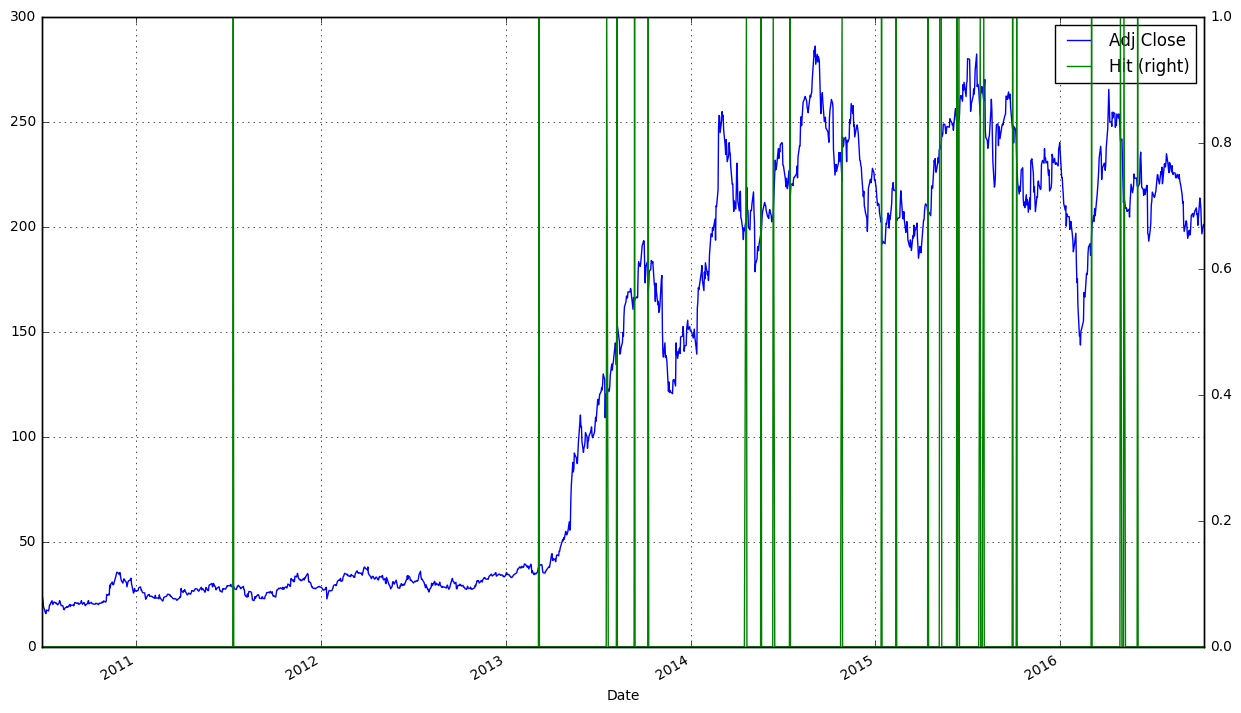

In [101]:
Tesla.plot(secondary_y='Hit', grid = True)